In [1]:
import sys
from gp_sinkhorn.gmm_torch.gmm import *
import numpy as np
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from TrajectoryNet.dataset import EBData
from TrajectoryNet.optimal_transport.emd import earth_mover_distance, interpolate_with_ot

from gp_sinkhorn.SDE_solver import solve_sde_RK
from gp_sinkhorn.MLE_drift import *
from gp_sinkhorn.utils import plot_trajectories_2

import torch

from celluloid import Camera
from IPython.display import HTML
import math


In [2]:
def plot(data, y):
    n = y.shape[0]

    fig, ax = plt.subplots(1, 1, figsize=(1.61803398875*4, 4))
    ax.set_facecolor('#bbbbbb')
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # plot the locations of all data points ..
    for i, point in enumerate(data.data):
        if i <= n//2:
            # .. separating them by ground truth ..
            ax.scatter(*point, color="#000000", s=3, alpha=.75, zorder=n+i)
        else:
            ax.scatter(*point, color="#ffffff", s=3, alpha=.75, zorder=n+i)

        if y[i] == 0:
            # .. as well as their predicted class
            ax.scatter(*point, zorder=i, color="#dbe9ff", alpha=.6, edgecolors=colors[1])
        else:
            ax.scatter(*point, zorder=i, color="#ffdbdb", alpha=.6, edgecolors=colors[5])

    handles = [plt.Line2D([0], [0], color='w', lw=4, label='Ground Truth 1'),
        plt.Line2D([0], [0], color='black', lw=4, label='Ground Truth 2'),
        plt.Line2D([0], [0], color=colors[1], lw=4, label='Predicted 1'),
        plt.Line2D([0], [0], color=colors[5], lw=4, label='Predicted 2')]

    legend = ax.legend(loc="best", handles=handles)

    plt.tight_layout()
    plt.show()

In [3]:
ds = EBData('pcs', max_dim=5)

Embedding shape  (16819, 100)
Labels shape  (16819,)
Embedding shape  (16819, 100)


In [4]:
data = torch.tensor(ds.get_data())
#data_sub = data[np.arange(0,data.shape[0],10)]

In [91]:
clf = GaussianMixture(15,5)

In [92]:
clf.fit(data)

Iter  0 / 100
Iter  1 / 100
Iter  2 / 100
Iter  3 / 100
Iter  4 / 100
Iter  5 / 100
Iter  6 / 100
Iter  7 / 100
Iter  8 / 100
Iter  9 / 100
Iter  10 / 100
Iter  11 / 100
Iter  12 / 100
Iter  13 / 100
Iter  14 / 100
Iter  15 / 100
Iter  16 / 100
Iter  17 / 100
Iter  18 / 100
Iter  19 / 100
Iter  20 / 100
Iter  21 / 100
Iter  22 / 100
Iter  23 / 100
Iter  24 / 100
Iter  25 / 100
Iter  26 / 100
Iter  27 / 100
Iter  28 / 100
Iter  29 / 100
Iter  30 / 100
Iter  31 / 100
Iter  32 / 100
Iter  33 / 100
Iter  34 / 100
Iter  35 / 100
Iter  36 / 100
Iter  37 / 100
Iter  38 / 100
Iter  39 / 100
Iter  40 / 100
Iter  41 / 100
Iter  42 / 100
Iter  43 / 100
Iter  44 / 100
Iter  45 / 100
Iter  46 / 100
Iter  47 / 100
Iter  48 / 100
Iter  49 / 100
Iter  50 / 100
Iter  51 / 100
Iter  52 / 100
Iter  53 / 100
Iter  54 / 100
Iter  55 / 100
Iter  56 / 100
Iter  57 / 100
Iter  58 / 100
Iter  59 / 100
Iter  60 / 100
Iter  61 / 100
Iter  62 / 100
Iter  63 / 100
Iter  64 / 100
Iter  65 / 100
Iter  66 / 100
Iter 

In [93]:
y = clf.predict(data)

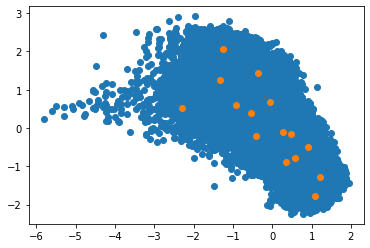

In [94]:
plt.scatter(data[:,0],data[:,1])
plt.scatter(clf.mu[0,:,0],clf.mu[0,:,1])

In [99]:
def pred_grad(clf,x,dim=2,return_pred=False):
    pred = clf.score_samples(x).backward()
    if return_pred:
        return x.grad.numpy()[:dim],pred
    else:
        return x.grad.numpy()[:dim]

In [100]:
idx = np.arange(0,grads.shape[0],500)
data_test = ds.get_data()
data_test_sub = data_test[idx]

In [101]:

x, y = np.meshgrid(data_test_sub[:,0], data_test_sub[:,1])
u = np.zeros(x.shape)
v = np.zeros(x.shape)
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        g,pred = pred_grad(clf,torch.tensor([x[i,j],y[i,j],1,1,1],requires_grad=True),return_pred=True)
        u[i,j] = g[0]
        v[i,j] = g[1]
        z[i,j] = pred

/Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  


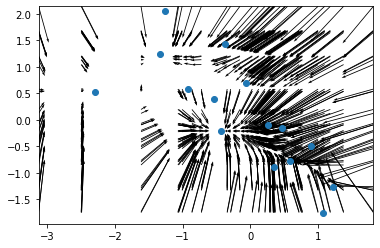

In [102]:

#norm = np.linalg.norm(np.array((u, v)), axis=0)
#u = (u / norm)*0.1
#v = (v / norm)*0.1

fig, ax = plt.subplots(1, 1)

ax.quiver(x, y, u, v, units='xy', scale=10)
ax.contour(x, y, z, 7, cmap='jet')
#plt.scatter(data[:,0],data[:,1])
plt.scatter(clf.mu[0,:,0],clf.mu[0,:,1])

In [103]:



prior_drift = lambda X: torch.tensor([pred_grad(clf,i) for i in X])